# Evaluation of the 3 datasets with ML

## Imports

In [1]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [2]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize (not number) / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

def prep_text(texts, tokenizer, **hparams):
    """
    Turns text into into padded sequences.
    """
    # kwargs.get("local", False)
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen = hparams["max_sequence_length"], padding='post')

def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)
    
def get_metrics(y_test, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julienseguy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienseguy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julienseguy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Parameters

In [44]:
hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 40
}

## Loading Datasets

### Loading `Politifact`

In [4]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [5]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: ['washington', 'public', 'school', 'force', 'unvaccinated', 'teen', 'wear', 'ankle', 'monitor', 'condition', 'playing', 'team', 'sport']
--------------------------------------------------------------------------------


In [6]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


In [124]:
tokenizer_P = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_P.fit_on_texts(X_P_train)

X_P_train_pad = prep_text(X_P_train, tokenizer_P, **hparams)
X_P_test_pad = prep_text(X_P_test, tokenizer_P, **hparams)

print('-'*80)
print(f"X_P_train_pad shape: {X_P_train_pad.shape}")
print(f"X_P_pad shape: {X_P_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_P.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train_pad shape: (15860, 40)
X_P_pad shape: (3966, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `FakeNewsNET`

In [8]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [9]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: ['djou', 'win', 'special', 'election', 'congress']
--------------------------------------------------------------------------------


In [10]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


In [125]:
tokenizer_F = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_F.fit_on_texts(X_P_train)

X_FNN_train_pad = prep_text(X_FNN_train, tokenizer_F, **hparams)
X_FNN_test_pad = prep_text(X_FNN_test, tokenizer_F, **hparams)

print('-'*80)
print(f"X_FNN_train_pad shape: {X_FNN_train_pad.shape}")
print(f"X_FNN_pad shape: {X_FNN_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_F.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_pad shape: (15424, 40)
X_FNN_pad shape: (3857, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `Bisaillon`

In [12]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [13]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [14]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [15]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: ['u', 'budget', 'fight', 'loom', 'republican', 'flip', 'fiscal', 'script']
--------------------------------------------------------------------------------


In [16]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


In [126]:
tokenizer_B = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_B.fit_on_texts(X_P_train)

X_BIS_train_pad = prep_text(X_BIS_train, tokenizer_B, **hparams)
X_BIS_test_pad = prep_text(X_BIS_test, tokenizer_B, **hparams)

print('-'*80)
print(f"X_BIS_train_pad shape: {X_BIS_train_pad.shape}")
print(f"X_BIS_pad shape: {X_BIS_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_B.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_pad shape: (35751, 40)
X_BIS_pad shape: (8938, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `Poynter`

In [18]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/poynter_final_condensed.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_PO = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_PO shape: {data_PO.shape}")
print('-'*80)
print('-'*80)
print(data_PO['label_list_transformed'].value_counts()/len(data_PO)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_PO shape: (14897, 3)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.0    50.063771
1.0    49.936229
Name: label_list_transformed, dtype: float64
--------------------------------------------------------------------------------


In [19]:
X_PO = data_PO['title_list'].apply(clean).copy()
y_PO = data_PO['label_list_transformed'].copy()

print('-'*80)
print(f"X_PO shape: {X_PO.shape}")
print(f"y_PO shape: {y_PO.shape}")
print('-'*80)
print(f"Original text: {data_PO['title_list'][0]}")
print(f"Clean text: {X_PO[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO shape: (14897,)
y_PO shape: (14897,)
--------------------------------------------------------------------------------
Original text: There is a call for free vaccination in the Ciudad de la Luz center, in Alicante, for people over 12 years old.
Clean text: ['call', 'free', 'vaccination', 'ciudad', 'de', 'la', 'luz', 'center', 'alicante', 'people', 'year', 'old']
--------------------------------------------------------------------------------


In [20]:
X_PO_train, X_PO_test, y_PO_train, y_PO_test = train_test_split(X_PO, y_PO, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_PO_train shape: {X_PO_train.shape}")
print(f"y_PO_train shape: {y_PO_train.shape}")
print('-'*80)
print(f"X_PO_test shape: {X_PO_test.shape}")
print(f"y_PO_test shape: {y_PO_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_PO_train.sum()/len(y_PO_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_PO_test.sum()/len(y_PO_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train shape: (11917,)
y_PO_train shape: (11917,)
--------------------------------------------------------------------------------
X_PO_test shape: (2980,)
y_PO_test shape: (2980,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 49.870
Fake (1) proportion in test (%): 50.201
--------------------------------------------------------------------------------


In [127]:
tokenizer_PO = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_PO.fit_on_texts(X_PO_train)

X_PO_train_pad = prep_text(X_PO_train, tokenizer_PO, **hparams)
X_PO_test_pad = prep_text(X_PO_test, tokenizer_PO, **hparams)

print('-'*80)
print(f"X_PO_train_pad shape: {X_PO_train_pad.shape}")
print(f"X_PO_pad shape: {X_PO_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_PO.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train_pad shape: (11917, 40)
X_PO_pad shape: (2980, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12086
--------------------------------------------------------------------------------


### Merging `Alll`

In [22]:
X_ALLL_train = pd.concat([X_P_train, X_FNN_train, X_BIS_train, X_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ALLL_train = pd.concat([y_P_train, y_FNN_train, y_BIS_train, y_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)

X_ALLL_test = pd.concat([X_P_test, X_FNN_test, X_BIS_test, X_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ALLL_test = pd.concat([y_P_test, y_FNN_test, y_BIS_test, y_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print('-'*80)
print(f"X_ALLL_train shape: {X_ALLL_train.shape}")
print(f"y_ALLL_train shape: {y_ALLL_train.shape}")
print('-'*80)
print(f"X_ALLL_test shape: {X_ALLL_test.shape}")
print(f"y_ALLL_test shape: {y_ALLL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALLL_train.sum()/len(y_ALLL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALLL_test.sum()/len(y_ALLL_test)*100:.3f}")
print('-'*80)
print('### TRAIN ###')
print('-'*80)
print(f"Politifact ratio: {X_P_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print('-'*80)
print('### TEST ###')
print('-'*80)
print(f"Politifact ratio: {X_P_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALLL_train shape: (78952,)
y_ALLL_train shape: (78952,)
--------------------------------------------------------------------------------
X_ALLL_test shape: (19741,)
y_ALLL_test shape: (19741,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 47.144
Fake (1) proportion in test (%): 46.543
--------------------------------------------------------------------------------
### TRAIN ###
--------------------------------------------------------------------------------
Politifact ratio: 0.20
FakeNewsNET ratio: 0.20
Bisaillon ratio: 0.45
Poynter ratio: 0.15
--------------------------------------------------------------------------------
### TEST ###
--------------------------------------------------------------------------------
Politifact ratio: 0.20
FakeNewsNET ratio:

In [128]:
tokenizer_ALLL = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_ALLL.fit_on_texts(X_ALLL_train)

X_ALLL_train_pad = prep_text(X_ALLL_train, tokenizer_ALLL, **hparams)
X_ALLL_test_pad = prep_text(X_ALLL_test, tokenizer_ALLL, **hparams)

print('-'*80)
print(f"X_ALLL_train_pad shape: {X_ALLL_train_pad.shape}")
print(f"X_ALLL_pad shape: {X_ALLL_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_ALLL.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALLL_train_pad shape: (78952, 40)
X_ALLL_pad shape: (19741, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 29940
--------------------------------------------------------------------------------


## Model

### Word2Vec

In [38]:
# import gensim.downloader
# # Show all available models in gensim-data
# print(list(gensim.downloader.info()['models'].keys()))

In [39]:
# glove_vectors = gensim.downloader.load('glove-twitter-25')

# glove_vectors.most_similar('twitter')

In [40]:
# from gensim.models import Word2Vec

# model = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, norm_only=True)

# dog = model['dog']
# print(dog.shape)
# print(dog[:10])

In [41]:
# from gensim.models import Word2Vec

# word2vec = Word2Vec(sentences=X_train, vector_size=10, min_count=10, window=10)

# Word2Vec.

# unique = set([_ for elt in X_train for _ in elt])

# print('-'*80)
# print(f"X_train vocabulary size: {len(unique)}")
# print(f"word2vec vocabulary size: {len(word2vec.wv.key_to_index)}")    
# print('-'*80)

In [42]:
# def embed_sentence(word2vec, sentence):
#     embed_matrix = []
#     for word in sentence:
#         if word in word2vec.wv.key_to_index:
#             embed_matrix.append(word2vec.wv[word])
#     return np.array(embed_matrix)

# def embedding(word2vec, sentences):
#     return [embed_sentence(word2vec, sentence) for sentence in sentences]

In [43]:
# X_train_embed = embedding(word2vec, X_train)
# X_test_embed = embedding(word2vec, X_test)

# X_train_embed[0].shape

In [ ]:
# and after padding ...

### Glove

In [24]:
import io
import urllib
import zipfile

zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_file = urllib.request.urlopen(zip_file_url)
archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

def get_embedding(archive, tokenizer, **hparams):
    """
    Pre-trained GloVe word vector embeddings
    """
    embeddings_index = {}
    glove_file = "glove.6B.100d.txt"

    with archive.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode("utf-8") 
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

### Model

In [25]:
METRICS = [
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

def init_model(embedding_matrix, metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model

2021-09-04 16:37:55.890487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## `Politifact`

### Model

In [99]:
embedding_matrix_P = get_embedding(archive, tokenizer_P, **hparams)

print('-'*80)
print(f"embedding_matrix_P shape: {embedding_matrix_P.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_P shape: (12714, 100)
--------------------------------------------------------------------------------


In [100]:
init_model(embedding_matrix_P, **hparams).summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 100)           1271400   
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 1, 128)          

### Training

In [101]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

P_model = init_model(embedding_matrix_P, **hparams)

history = P_model.fit(X_P_train_pad, 
                  y_P_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
100/100 [==============================] - 3s 24ms/step - loss: 0.6601 - accuracy: 0.7221 - precision: 0.7302 - recall: 0.7617 - val_loss: 0.6285 - val_accuracy: 0.6387 - val_precision: 0.6464 - val_recall: 0.7471
Epoch 2/30
100/100 [==============================] - 2s 22ms/step - loss: 0.6069 - accuracy: 0.6524 - precision: 0.6896 - recall: 0.6528 - val_loss: 0.6317 - val_accuracy: 0.6217 - val_precision: 0.7748 - val_recall: 0.4330
Epoch 3/30
100/100 [==============================] - 2s 23ms/step - loss: 0.5730 - accuracy: 0.6856 - precision: 0.7494 - recall: 0.6314 - val_loss: 0.6370 - val_accuracy: 0.6438 - val_precision: 0.6796 - val_recall: 0.6576
Epoch 4/30
100/100 [==============================] - 2s 21ms/step - loss: 0.5246 - accuracy: 0.7213 - precision: 0.7842 - recall: 0.6706 - val_loss: 0.7047 - val_accuracy: 0.6207 - val_precision: 0.6952 - val_recall: 0.5439
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.4659 - accuracy: 0.7581

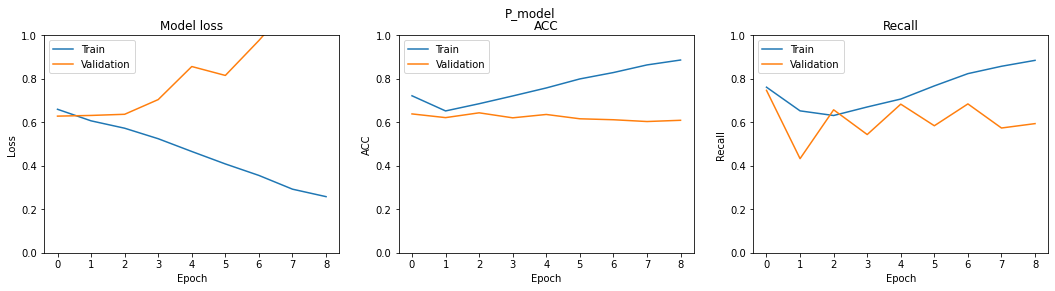

In [102]:
plot_loss(history, title='P_model')

--------------------------------------------------------------------------------
acc: 63.89%
recall: 74.33%
precision: 64.23%
f1: 68.91%
--------------------------------------------------------------------------------


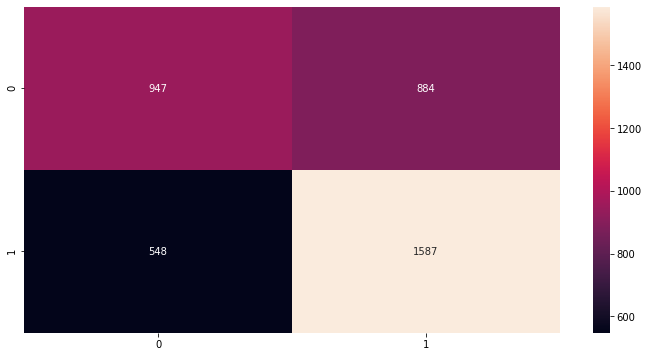

In [130]:
get_metrics(y_P_test, X_P_test_pad, P_model)

### Saving the model

In [131]:
# Colab
# model_name = 'P_model'

# Notebook
model_name = '../raw_data/P_model'

P_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/P_model/assets


### Uploading the model

In [132]:
reconstructed_P_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 63.89%
recall: 74.33%
precision: 64.23%
f1: 68.91%
--------------------------------------------------------------------------------


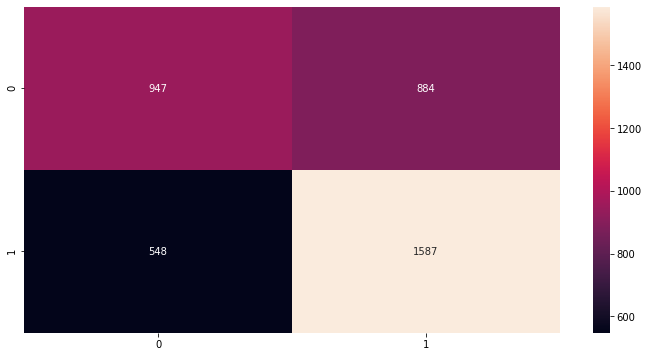

In [133]:
get_metrics(y_P_test, X_P_test_pad, reconstructed_P_model)

### `P_model` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 30.33%
recall: 94.42%
precision: 25.38%
f1: 40.01%
--------------------------------------------------------------------------------


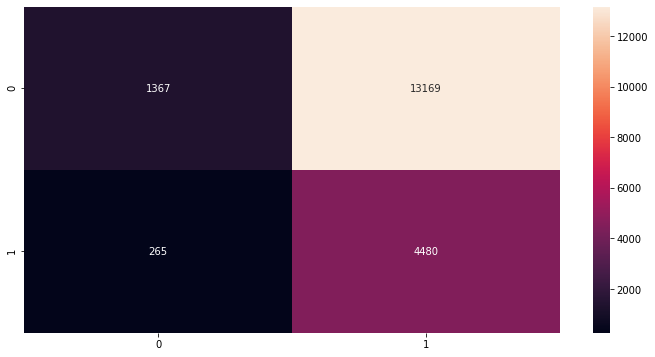

In [45]:
X_FNN_pad = prep_text(X_FNN, tokenizer_P, **hparams)

get_metrics(y_FNN, X_FNN_pad, reconstructed_P_model)

### `P_model` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 54.28%
recall: 91.78%
precision: 53.81%
f1: 67.84%
--------------------------------------------------------------------------------


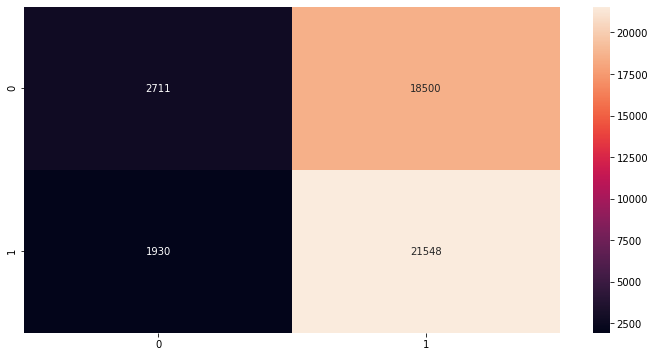

In [46]:
X_BIS_pad = prep_text(X_BIS, tokenizer_P, **hparams)

get_metrics(y_BIS, X_BIS_pad, reconstructed_P_model)

## `FakeNewsNET`

### Model

In [107]:
embedding_matrix_F = get_embedding(archive, tokenizer_F, **hparams)

print('-'*80)
print(f"embedding_matrix_F shape: {embedding_matrix_F.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_F shape: (12714, 100)
--------------------------------------------------------------------------------


In [108]:
init_model(embedding_matrix_F, **hparams).summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 40, 100)           1271400   
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 1, 128)          

### Training

In [109]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

F_model = init_model(embedding_matrix_F, **hparams)

history = F_model.fit(X_FNN_train_pad, 
                  y_FNN_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
97/97 [==============================] - 3s 23ms/step - loss: 0.5268 - accuracy: 0.7202 - precision: 0.6187 - recall: 0.2458 - val_loss: 0.4921 - val_accuracy: 0.7731 - val_precision: 0.7468 - val_recall: 0.1482
Epoch 2/30
97/97 [==============================] - 2s 23ms/step - loss: 0.4514 - accuracy: 0.7986 - precision: 0.6936 - recall: 0.3366 - val_loss: 0.4575 - val_accuracy: 0.7929 - val_precision: 0.7021 - val_recall: 0.3067
Epoch 3/30
97/97 [==============================] - 2s 23ms/step - loss: 0.3864 - accuracy: 0.8311 - precision: 0.7450 - recall: 0.4850 - val_loss: 0.4664 - val_accuracy: 0.7887 - val_precision: 0.6080 - val_recall: 0.4497
Epoch 4/30
97/97 [==============================] - 2s 24ms/step - loss: 0.3134 - accuracy: 0.8681 - precision: 0.7848 - recall: 0.6448 - val_loss: 0.5424 - val_accuracy: 0.7802 - val_precision: 0.5888 - val_recall: 0.4188
Epoch 5/30
97/97 [==============================] - 2s 22ms/step - loss: 0.2470 - accuracy: 0.8946 - precisi

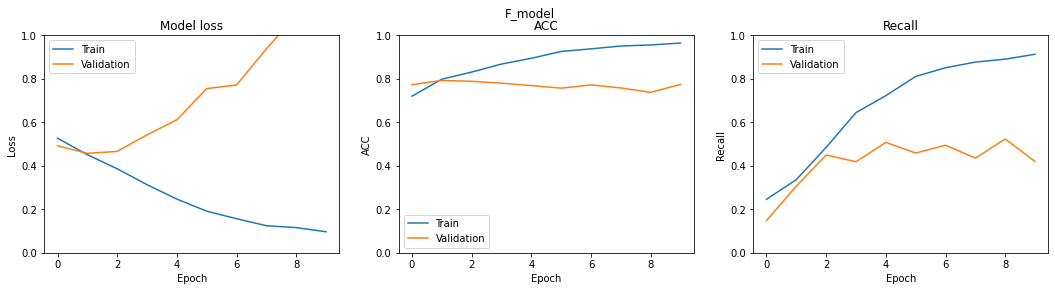

In [112]:
plot_loss(history, title='F_model')

--------------------------------------------------------------------------------
acc: 80.04%
recall: 29.37%
precision: 67.59%
f1: 40.95%
--------------------------------------------------------------------------------


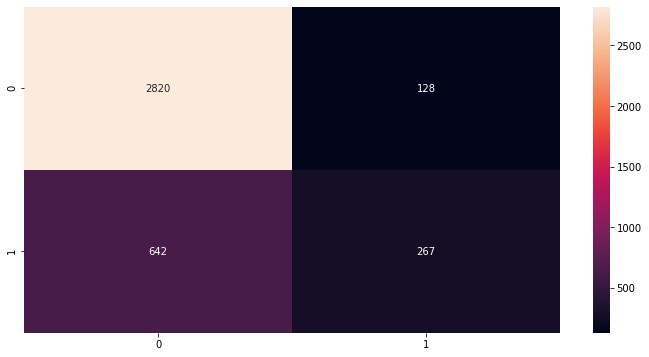

In [134]:
get_metrics(y_FNN_test, X_FNN_test_pad, F_model)

### Saving the model

In [135]:
# Colab
# model_name = 'F_model'

# Notebook
model_name = '../raw_data/F_model'

F_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/F_model/assets


### Uploading the model

In [136]:
reconstructed_F_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 80.04%
recall: 29.37%
precision: 67.59%
f1: 40.95%
--------------------------------------------------------------------------------


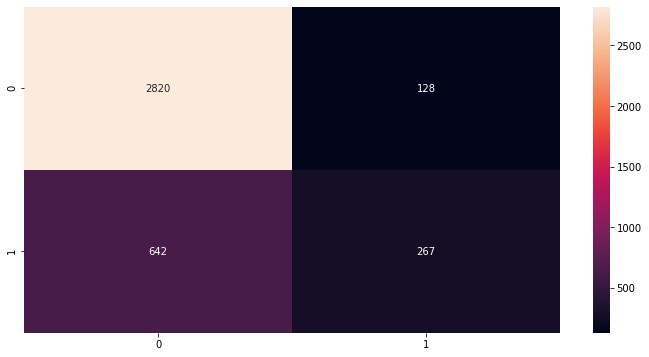

In [137]:
get_metrics(y_FNN_test, X_FNN_test_pad, reconstructed_F_model)

### `F_model` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 46.97%
recall: 10.21%
precision: 47.81%
f1: 16.82%
--------------------------------------------------------------------------------


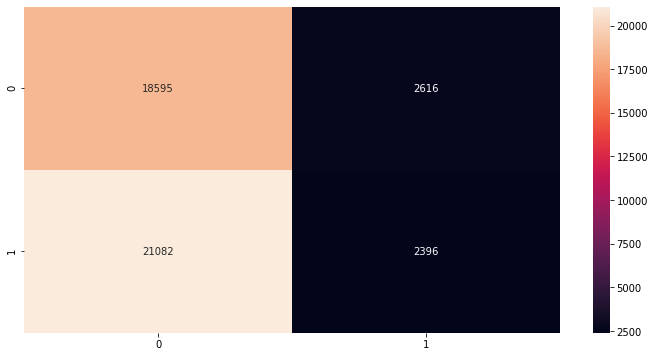

In [58]:
X_BIS_pad = prep_text(X_BIS, tokenizer_F, **hparams)

get_metrics(y_BIS, X_BIS_pad, reconstructed_F_model)

### `F_model` evaluation on  `politifact_scrap`

--------------------------------------------------------------------------------
acc: 47.95%
recall: 13.09%
precision: 58.97%
f1: 21.43%
--------------------------------------------------------------------------------


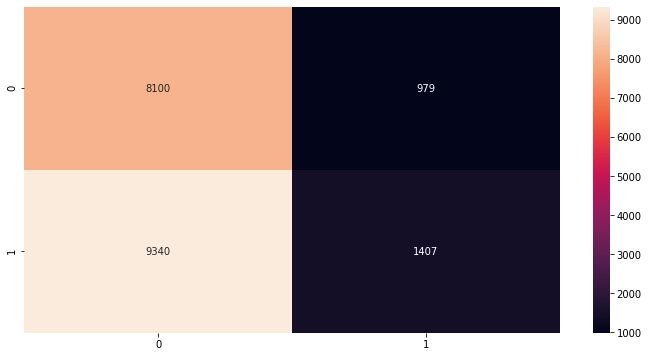

In [59]:
X_P_pad = prep_text(X_P, tokenizer_F, **hparams)

get_metrics(y_P, X_P_pad, reconstructed_F_model)

## `Bisaillon`

### Model

In [89]:
embedding_matrix_B = get_embedding(archive, tokenizer_B, **hparams)

print('-'*80)
print(f"embedding_matrix_B shape: {embedding_matrix_B.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_B shape: (12714, 100)
--------------------------------------------------------------------------------


In [90]:
init_model(embedding_matrix_B, **hparams).summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 100)           1271400   
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 1, 128)          

### Training

In [91]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

B_model = init_model(embedding_matrix_B, **hparams)

history = B_model.fit(X_BIS_train_pad, 
                  y_BIS_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
224/224 [==============================] - 6s 22ms/step - loss: 0.2543 - accuracy: 0.8857 - precision: 0.8947 - recall: 0.8871 - val_loss: 0.2318 - val_accuracy: 0.9097 - val_precision: 0.8882 - val_recall: 0.9458
Epoch 2/30
224/224 [==============================] - 4s 18ms/step - loss: 0.1636 - accuracy: 0.9380 - precision: 0.9469 - recall: 0.9351 - val_loss: 0.2599 - val_accuracy: 0.9027 - val_precision: 0.9667 - val_recall: 0.8423
Epoch 3/30
224/224 [==============================] - 4s 19ms/step - loss: 0.1173 - accuracy: 0.9562 - precision: 0.9648 - recall: 0.9519 - val_loss: 0.2093 - val_accuracy: 0.9200 - val_precision: 0.9013 - val_recall: 0.9506
Epoch 4/30
224/224 [==============================] - 5s 22ms/step - loss: 0.0822 - accuracy: 0.9697 - precision: 0.9763 - recall: 0.9660 - val_loss: 0.2302 - val_accuracy: 0.9259 - val_precision: 0.9471 - val_recall: 0.9085
Epoch 5/30
224/224 [==============================] - 5s 21ms/step - loss: 0.0615 - accuracy: 0.9776

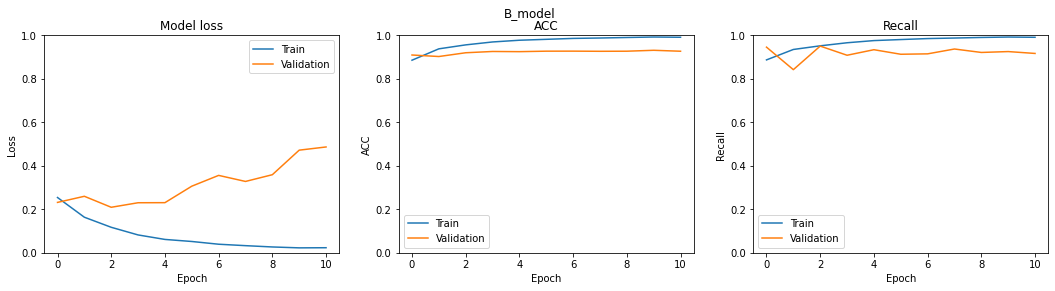

In [92]:
plot_loss(history, title='B_model')

--------------------------------------------------------------------------------
acc: 92.26%
recall: 95.61%
precision: 90.11%
f1: 92.78%
--------------------------------------------------------------------------------


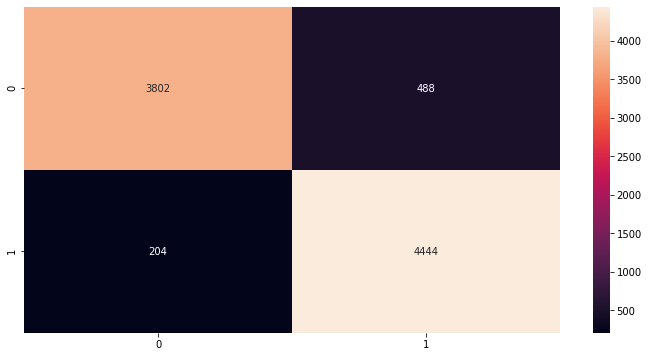

In [138]:
get_metrics(y_BIS_test, X_BIS_test_pad, B_model)

### Saving the model

In [139]:
# Colab
# model_name = 'B_model'

# Notebook
model_name = '../raw_data/B_model'

B_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/B_model/assets


### Uploading the model

In [140]:
reconstructed_B_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 92.26%
recall: 95.61%
precision: 90.11%
f1: 92.78%
--------------------------------------------------------------------------------


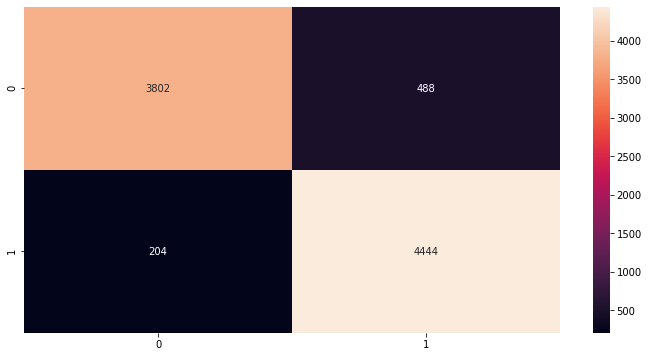

In [141]:
get_metrics(y_BIS_test, X_BIS_test_pad, reconstructed_B_model)

### `B_model` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 38.03%
recall: 79.83%
precision: 25.63%
f1: 38.80%
--------------------------------------------------------------------------------


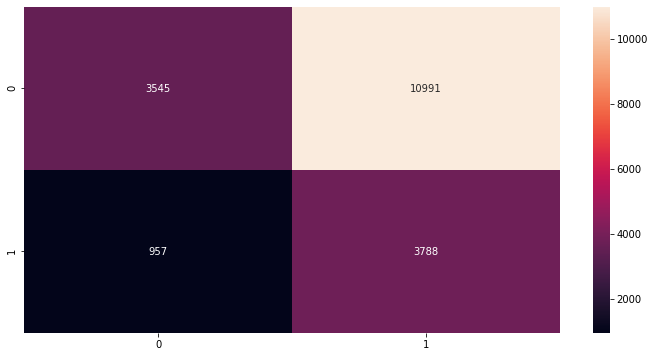

In [69]:
X_FNN_pad = prep_text(X_FNN, tokenizer_B, **hparams)

get_metrics(y_FNN, X_FNN_pad, reconstructed_B_model)

### `B_model` evaluation on `politifact scrap`

--------------------------------------------------------------------------------
acc: 52.70%
recall: 76.72%
precision: 54.53%
f1: 63.75%
--------------------------------------------------------------------------------


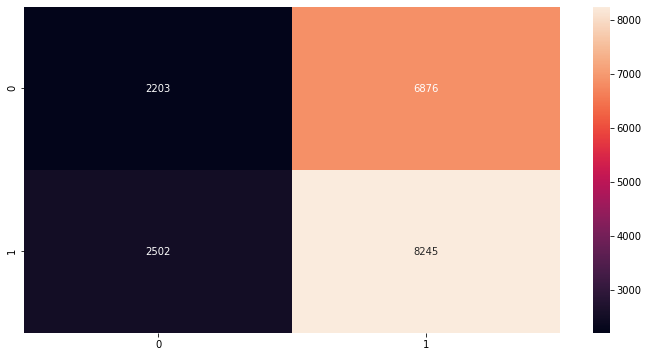

In [70]:
X_P_pad = prep_text(X_P, tokenizer_B, **hparams)

get_metrics(y_P, X_P_pad, reconstructed_B_model)

## `Poynter`

### Model

In [72]:
embedding_matrix_PO = get_embedding(archive, tokenizer_PO, **hparams)

print('-'*80)
print(f"embedding_matrix_PO shape: {embedding_matrix_PO.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_PO shape: (12087, 100)
--------------------------------------------------------------------------------


In [73]:
init_model(embedding_matrix_PO, **hparams).summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 100)           1208700   
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 1, 128)           

### Training

In [74]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

PO_model = init_model(embedding_matrix_PO, **hparams)

history = PO_model.fit(X_PO_train_pad, 
                  y_PO_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
75/75 [==============================] - 2s 22ms/step - loss: 0.5637 - accuracy: 0.7318 - precision: 0.7192 - recall: 0.7582 - val_loss: 0.4857 - val_accuracy: 0.7789 - val_precision: 0.7456 - val_recall: 0.8474
Epoch 2/30
75/75 [==============================] - 1s 20ms/step - loss: 0.4206 - accuracy: 0.8145 - precision: 0.7940 - recall: 0.8478 - val_loss: 0.4568 - val_accuracy: 0.7970 - val_precision: 0.7913 - val_recall: 0.8072
Epoch 3/30
75/75 [==============================] - 1s 19ms/step - loss: 0.3243 - accuracy: 0.8661 - precision: 0.8462 - recall: 0.8939 - val_loss: 0.5084 - val_accuracy: 0.7773 - val_precision: 0.8357 - val_recall: 0.6907
Epoch 4/30
75/75 [==============================] - 1s 19ms/step - loss: 0.2352 - accuracy: 0.9041 - precision: 0.8951 - recall: 0.9147 - val_loss: 0.5730 - val_accuracy: 0.7999 - val_precision: 0.8024 - val_recall: 0.7963
Epoch 5/30
75/75 [==============================] - 2s 22ms/step - loss: 0.1737 - accuracy: 0.9329 - precisi

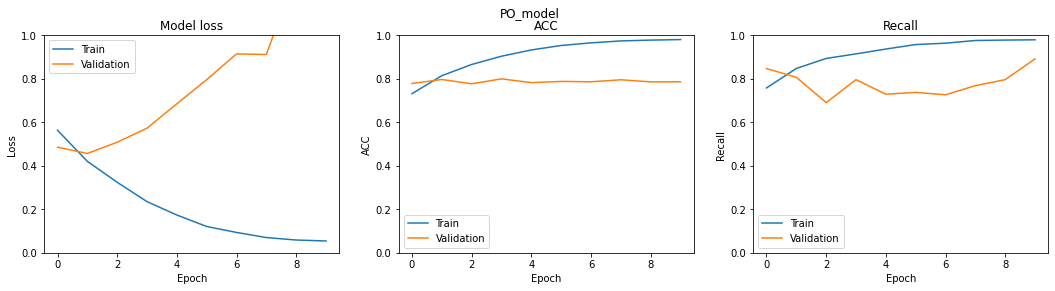

In [75]:
plot_loss(history, title='PO_model')

--------------------------------------------------------------------------------
acc: 79.53%
recall: 80.35%
precision: 79.18%
f1: 79.76%
--------------------------------------------------------------------------------


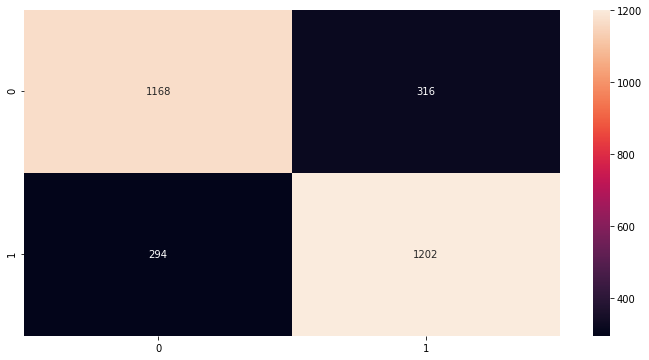

In [142]:
get_metrics(y_PO_test, X_PO_test_pad, PO_model)

### Saving the model

In [143]:
# Colab
# model_name = 'PO_model'

# Notebook
model_name = '../raw_data/PO_model'

PO_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/PO_model/assets


### Uploading the model

In [144]:
reconstructed_PO_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 79.53%
recall: 80.35%
precision: 79.18%
f1: 79.76%
--------------------------------------------------------------------------------


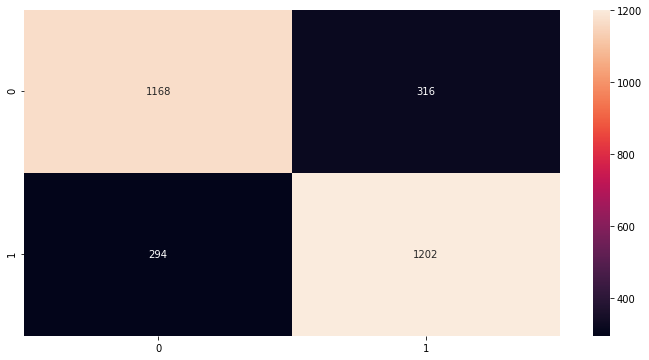

In [145]:
get_metrics(y_PO_test, X_PO_test_pad, reconstructed_PO_model)

## `Alll`

### Model

In [26]:
embedding_matrix_ALLL = get_embedding(archive, tokenizer_ALLL, **hparams)

print('-'*80)
print(f"embedding_matrix_ALLL shape: {embedding_matrix_ALLL.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_ALLL shape: (29941, 100)
--------------------------------------------------------------------------------


In [173]:
def init_model(embedding_matrix, metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model

In [174]:
init_model(embedding_matrix_ALLL, **hparams).summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 40, 100)           2994100   
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_95 (MaxPooling (None, 1, 128)          

### Training

In [175]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

ALLL_model = init_model(embedding_matrix_ALLL, **hparams)

history = ALLL_model.fit(X_ALLL_train_pad, 
                  y_ALLL_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
494/494 [==============================] - 14s 27ms/step - loss: 0.4832 - accuracy: 0.7622 - precision: 0.7691 - recall: 0.7082 - val_loss: 0.4366 - val_accuracy: 0.7817 - val_precision: 0.8507 - val_recall: 0.6516
Epoch 2/30
494/494 [==============================] - 13s 26ms/step - loss: 0.3985 - accuracy: 0.8080 - precision: 0.8230 - recall: 0.7550 - val_loss: 0.4285 - val_accuracy: 0.7908 - val_precision: 0.7659 - val_recall: 0.8016
Epoch 3/30
494/494 [==============================] - 13s 26ms/step - loss: 0.3532 - accuracy: 0.8326 - precision: 0.8427 - recall: 0.7928 - val_loss: 0.4154 - val_accuracy: 0.8006 - val_precision: 0.7830 - val_recall: 0.7988
Epoch 4/30
494/494 [==============================] - 13s 26ms/step - loss: 0.3100 - accuracy: 0.8539 - precision: 0.8605 - recall: 0.8235 - val_loss: 0.4722 - val_accuracy: 0.7991 - val_precision: 0.7678 - val_recall: 0.8231
Epoch 5/30
494/494 [==============================] - 13s 25ms/step - loss: 0.2785 - accuracy: 0

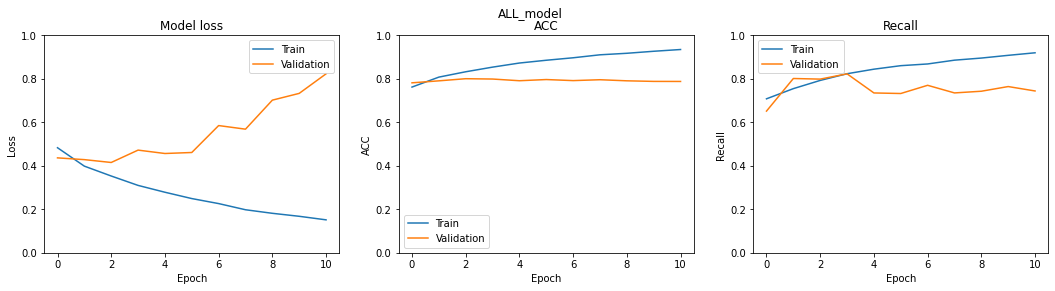

In [177]:
plot_loss(history, title='ALL_model')

--------------------------------------------------------------------------------
acc: 80.07%
recall: 79.65%
precision: 77.99%
f1: 78.81%
--------------------------------------------------------------------------------


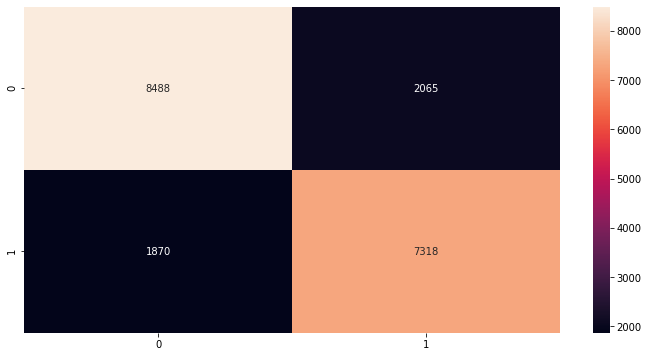

In [178]:
get_metrics(y_ALLL_test, X_ALLL_test_pad, ALLL_model)

### Saving the model

In [179]:
# Colab
# model_name = 'ALL_model'

# Notebook
model_name = '../raw_data/ALLL_model'

ALLL_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/ALLL_model/assets


### Uploading the model

In [34]:
reconstructed_ALLL_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 78.80%
recall: 80.89%
precision: 75.37%
f1: 78.03%
--------------------------------------------------------------------------------


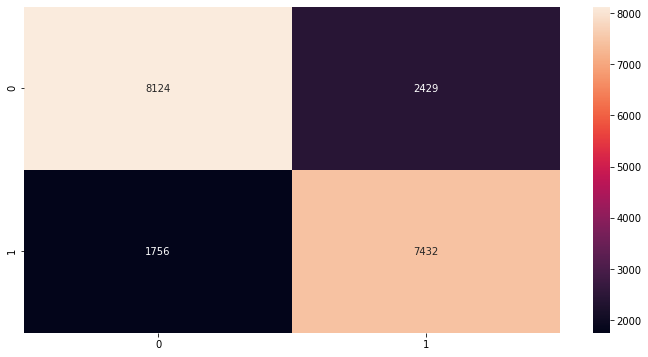

In [146]:
get_metrics(y_ALLL_test, X_ALLL_test_pad, reconstructed_ALLL_model)

### `ALLL_model` evaluation on `Politifact`

--------------------------------------------------------------------------------
acc: 58.35%
recall: 62.39%
precision: 61.07%
f1: 61.72%
--------------------------------------------------------------------------------


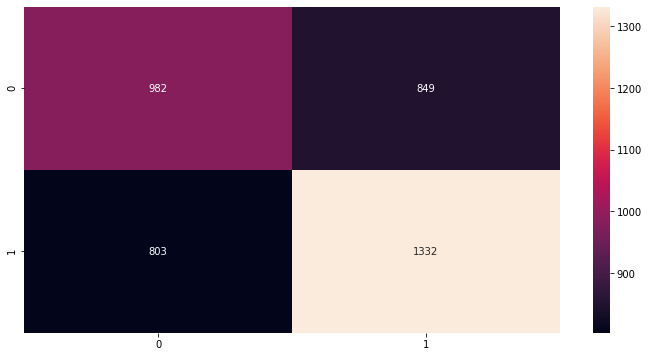

In [37]:
X_P_test_pad = prep_text(X_P_test, tokenizer_ALLL, **hparams)

get_metrics(y_P_test, X_P_test_pad, reconstructed_ALLL_model)

### `ALLL_model` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 71.38%
recall: 65.57%
precision: 42.97%
f1: 51.92%
--------------------------------------------------------------------------------


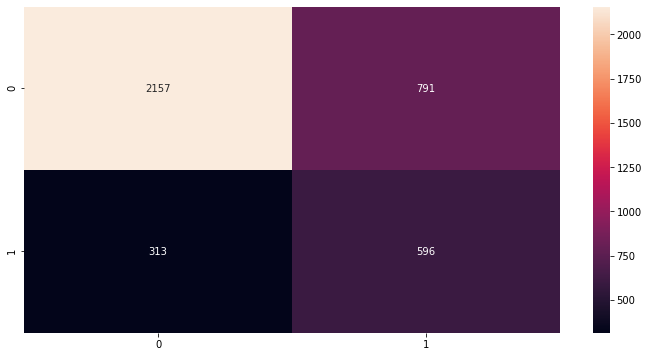

In [38]:
X_FNN_test_pad = prep_text(X_FNN_test, tokenizer_ALLL, **hparams)

get_metrics(y_FNN_test, X_FNN_test_pad, reconstructed_ALLL_model)

### `ALLL_model` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 92.20%
recall: 91.50%
precision: 93.37%
f1: 92.43%
--------------------------------------------------------------------------------


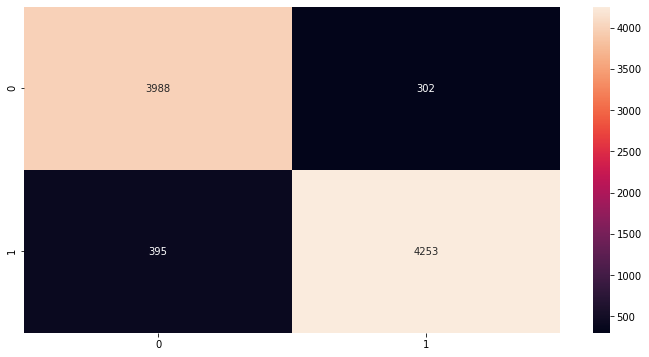

In [39]:
X_BIS_test_pad = prep_text(X_BIS_test, tokenizer_ALLL, **hparams)

get_metrics(y_BIS_test, X_BIS_test_pad, reconstructed_ALLL_model)

### `ALL_model` evaluation on `Poynter`

--------------------------------------------------------------------------------
acc: 75.44%
recall: 83.62%
precision: 71.98%
f1: 77.37%
--------------------------------------------------------------------------------


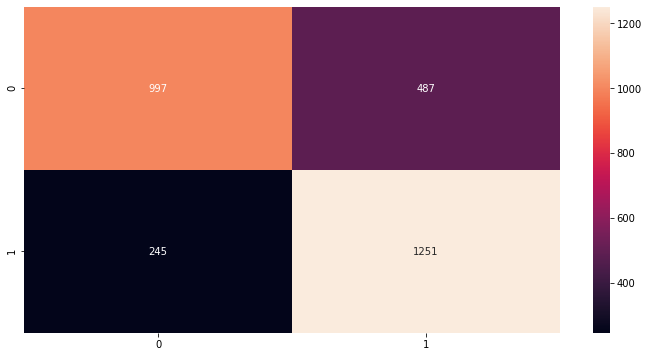

In [40]:
X_PO_test_pad = prep_text(X_PO_test, tokenizer_ALLL, **hparams)

get_metrics(y_PO_test, X_PO_test_pad, reconstructed_ALLL_model)

## Summary

In [82]:
def get_summary(model_names, datas, tokenizers):

    X_data = [[X_P_test, X_FNN, X_BIS, X_PO, X_ALLL_test],
              [X_P, X_FNN_test, X_BIS, X_PO, X_ALLL_test],
              [X_P, X_FNN, X_BIS_test, X_PO, X_ALLL_test],
              [X_P, X_FNN, X_BIS, X_PO_test, X_ALLL_test],
              [X_P_test, X_FNN_test, X_BIS_test, X_PO_test, X_ALLL_test]]

    y_data = [[y_P_test, y_FNN, y_BIS, y_PO, y_ALLL_test],
              [y_P, y_FNN_test, y_BIS, y_PO, y_ALLL_test],
              [y_P, y_FNN, y_BIS_test, y_PO, y_ALLL_test],
              [y_P, y_FNN, y_BIS, y_PO_test, y_ALLL_test],
              [y_P_test, y_FNN_test, y_BIS_test, y_PO_test, y_ALLL_test]]

    model_list = []
    data_list = []
    tokenizer_list = []
    acc_list = []
    recall_list = []
    prec_list = []
    f1_list = []
    
    for model_name, tokenizer, Xs, ys in zip(model_names, tokenizers, X_data, y_data):

        for data, X, y in zip(datas, Xs, ys):

#             print('-'*80)
#             print(model_name)
#             print(data)
#             print(X.shape)
#             print(y.shape)

            X_pad = prep_text(X, tokenizer, **hparams)
            reconstructed_model = tf.keras.models.load_model(model_names[model_name])
            y_probs = reconstructed_model.predict(X_pad)
            y_preds = np.where(y_probs > 0.5, 1, 0)

            model_list.append(model_name)
            data_list.append(data)
            acc_list.append(np.round(accuracy_score(y, y_preds), 2))
            recall_list.append(np.round(recall_score(y, y_preds), 2))
            prec_list.append(np.round(precision_score(y, y_preds), 2))
            f1_list.append(np.round(f1_score(y, y_preds), 2))

    df = pd.DataFrame({'model': model_list, 
                   'data': data_list, 
                   'acc': acc_list,
                   'recall': recall_list, 
                   'prec': prec_list,
                   'f1': f1_list,
    })

    return df

In [117]:
model_names = {'a_P_model': '../raw_data/P_model',
               'b_FNN_model': '../raw_data/F_model', 
               'c_BI_model': '../raw_data/B_model',
               'd_PO_model': '../raw_data/PO_model',
               'e_ALLL_model': '../raw_data/ALLL_model'
              }

datas = ['a_P', 'b_FNN', 'c_BI', 'd_PO', 'e_ALLL']

tokenizers = [tokenizer_P, 
             tokenizer_F,
             tokenizer_B,
             tokenizer_PO,
             tokenizer_ALLL]

df = get_summary(model_names, datas, tokenizers)

In [118]:
df.head(20)

,model,data,acc,recall,prec,f1
0,a_P_model,a_P,0.64,0.74,0.64,0.69
1,a_P_model,b_FNN,0.28,0.97,0.25,0.40
2,a_P_model,c_BI,0.54,0.98,0.54,0.69
3,a_P_model,d_PO,0.53,0.94,0.51,0.66
4,a_P_model,e_ALLL,0.50,0.91,0.48,0.63
5,b_FNN_model,a_P,0.48,0.15,0.60,0.24
6,b_FNN_model,b_FNN,0.80,0.29,0.68,0.41
7,b_FNN_model,c_BI,0.54,0.20,0.71,0.31
8,b_FNN_model,d_PO,0.44,0.10,0.31,0.16
9,b_FNN_model,e_ALLL,0.56,0.18,0.59,0.27


In [119]:
df.pivot(index='model', columns='data', values='acc')

data,a_P,b_FNN,c_BI,d_PO,e_ALLL
model,,,,,
a_P_model,0.64,0.28,0.54,0.53,0.50
b_FNN_model,0.48,0.80,0.54,0.44,0.56
c_BI_model,0.54,0.35,0.92,0.44,0.66
d_PO_model,0.51,0.41,0.46,0.80,0.51
e_ALLL_model,0.59,0.71,0.92,0.75,0.79


In [120]:
file_path = '../raw_data/DL_summary.csv'

df.to_csv(file_path, index=False)

## Prediction

In [98]:
# Colab
model_name = 'ALL_model'

# Notebook
model_name = '../raw_data/ALL_model'

reconstructed_ALL_model = tf.keras.models.load_model(model_name)

In [99]:
fake0 = "White House, CDC, WHO and vaccine makers don’t require the COVID-19 vaccine for their workers."
fake1 = "Says a U.S. Air Force-insignia plane evacuating people from Afghanistan is fake."
fake2 = "No one has died of cancer or heart disease since the COVID-19 thing started."
true0 = "A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida."
true1 = "We’ve got 115,000 miles of roads in this state and 90% is owned by the locals."
true2 = "324,000 pregnant people experience domestic violence during their pregnancy."

In [102]:
sample = [fake0, fake1, fake2, true0, true1, true2]

# Preprocessing
X_sample_clean = [clean(text) for text in sample] 
X_sample_pad = prep_text(X_sample_clean, tokenizer_ALL, **hparams)

# Prediction
y_preds = reconstructed_ALL_model.predict(X_sample_pad)

print('-'*80)
print(y_preds)
print('-'*80)

--------------------------------------------------------------------------------
[[0.85778475]
 [0.77794206]
 [0.4333899 ]
 [0.83911407]
 [0.47911212]
 [0.31759608]]
--------------------------------------------------------------------------------
